#### Name: Andrew Shapiro
#### Date: 12/04/2024
#### Exercise: Project #3 Sentiment Analysis of Reviews
#### Description: This notebook will use the Yelp API to look at hotel reviews in New York City, create a WordCloud, and perform sentiment analysis on them.

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import yelpkeys  # file where client_id and api_key is defined with user's private app information
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk
from nltk.corpus import stopwords
from operator import itemgetter
import pandas as pd
from wordcloud import WordCloud

### Introduction 
*"An overall question that you have about your dataset, along with your name and date and description of the problem and summary of your solution."*

You can find my name and date present at the top of this notebook as part of my Project Header. My problem is, New York City, is home to many tourist attractions, which means they are also a busy hub for hotels for tourists. I want to know whether or not using a select sample of reviews from hotels in New York City, is the overall opinion of what New York City hotels have to offer a positive or negative? What's the most commom wording in all reviews? My solution is to use the API to find all of the hotels in New York City, and go ahead and review each of the reviews. From there, I will go ahead and plot a donut chart of the selected sample of reviews and create a WordCloud of all of the reviews?

### **(a)** Use the API to search for at least 60 reviews about your topic. (Note Yelp Fusion only delivers 3 reviews per business.)

Before we go ahead and start using the API to search at least 60 reviews about hotels in New York CIty, I will paste the code below that contains all of the functions and authorization for us to be able to use Yelp Fusion.

In [3]:
APIKEY = yelpkeys.api_key
headers = {'Authorization': 'Bearer %s' % yelpkeys.api_key,}

In [4]:
"""
Yelp Fusion API code sample.
This program demonstrates the capability of the Yelp Fusion API
by using the Search API to query for businesses by a search term and location,
and the Business API to query additional information about the top result
from the search query.
Please refer to https://docs.developer.yelp.com/docs/get-started for the API
documentation.
This program requires the Python requests library, which you can install via:
`pip install -r requirements.txt`.
Sample usage of the program:
`python sample.py --term="bars" --location="San Francisco, CA"`
"""
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib


# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode


# Yelp Fusion no longer uses OAuth as of December 7, 2017.
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app
API_KEY= yelpkeys.api_key


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.


# Defaults for our simple example.
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 20


def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()


def search(api_key, term, location):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)


def get_business(api_key, business_id):
    """Query the Business API by a business ID.
    Args:
        business_id (str): The ID of the business to query.
    Returns:
        dict: The JSON response from the request.
    """
    business_path = BUSINESS_PATH + business_id

    return request(API_HOST, business_path, api_key)


def query_api(term, location):
    """Queries the API by the input values from the user.
    Args:
        term (str): The search term to query.
        location (str): The location of the business to query.
    """
    response = search(API_KEY, term, location)

    businesses = response.get('businesses')

    if not businesses:
        print(u'No businesses for {0} in {1} found.'.format(term, location))
        return

    business_id = businesses[0]['id']

    print(u'{0} businesses found, querying business info ' \
        'for the top result "{1}" ...'.format(
            len(businesses), business_id))
    response = get_business(API_KEY, business_id)

    print(u'Result for business "{0}" found:'.format(business_id))
    pprint.pprint(response, indent=2)

Using the API above, I will run the search function using the API Key you provided to us, the search term "hotel" as that is what our research is about, and the place, "New York, NY" which is the specific location where we want to analyze hotels in or nearby.

In [5]:
response = search(API_KEY,"hotel", 'New York, NY')

Querying https://api.yelp.com/v3/businesses/search ...


In [6]:
response

{'businesses': [{'id': 'SoSQhqqOaS10aUuxDr1YtA',
   'alias': 'citizenm-new-york-times-square-hotel-new-york',
   'name': 'citizenM New York Times Square Hotel',
   'image_url': 'https://s3-media4.fl.yelpcdn.com/bphoto/WjdK9q6GkEU_HrBsn8ehFA/o.jpg',
   'is_closed': False,
   'url': 'https://www.yelp.com/biz/citizenm-new-york-times-square-hotel-new-york?adjust_creative=istl9jgw2i0Hp64EIdomvQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=istl9jgw2i0Hp64EIdomvQ',
   'review_count': 264,
   'categories': [{'alias': 'hotels', 'title': 'Hotels'}],
   'rating': 4.3,
   'coordinates': {'latitude': 40.76157679275397,
    'longitude': -73.98495063720071},
   'transactions': [],
   'price': '$$',
   'location': {'address1': '218 W 50th St',
    'address2': '',
    'address3': '',
    'city': 'New York',
    'zip_code': '10019',
    'country': 'US',
    'state': 'NY',
    'display_address': ['218 W 50th St', 'New York, NY 10019']},
   'phone': '+12124613638',
   'display_pho

Now, we have a list of 20 hotels that we can take 3 reviews from each for our analysis.

In [7]:
# Creating a list that will hold the values of the Yelp Fusion output.
master = []

# Going through all businesses and appending the name, rating, review_count, and reviews to our master list.
for business in response['businesses']:
    BUS_REVIEW='/v3/businesses/{}/reviews'.format(business['id'])
    reviews = request(API_HOST,BUS_REVIEW, API_KEY)
    
    # This is just how we will go ahead and collect all of our reviews and make it a list.
    business_reviews = []
    for review in reviews['reviews']:
        business_reviews.append(review['text'])
        blob = TextBlob(review['text'])
        
    master.append([business['name'], business['rating'], business['review_count'], business_reviews])
    print('Added ' + business['name'])

master

Querying https://api.yelp.com/v3/businesses/SoSQhqqOaS10aUuxDr1YtA/reviews ...
Added citizenM New York Times Square Hotel
Querying https://api.yelp.com/v3/businesses/GYO8lvStXGZAfFDRlOxQ1Q/reviews ...
Added Hotel 50 Bowery
Querying https://api.yelp.com/v3/businesses/jq9WOcjuFe595Rf8I87Y0Q/reviews ...
Added Casablanca Hotel
Querying https://api.yelp.com/v3/businesses/6H427bZqS7bqAR-tU8GKDw/reviews ...
Added 1 Hotel Brooklyn Bridge
Querying https://api.yelp.com/v3/businesses/J0bkcxkGKZuaghjiPUc4MA/reviews ...
Added Hilton Garden Inn New York/Tribeca
Querying https://api.yelp.com/v3/businesses/cUXl19vPkfd9vdqc0OT7_g/reviews ...
Added The Ludlow New York City
Querying https://api.yelp.com/v3/businesses/dQFgUq-bSGmfiSYtMo7mnQ/reviews ...
Added Hampton Inn Brooklyn/Downtown
Querying https://api.yelp.com/v3/businesses/3wPJT190GyZNB-Nor2Gwmw/reviews ...
Added Ace Hotel - Brooklyn
Querying https://api.yelp.com/v3/businesses/vEGyBSEqvWrU_uz0yuRydQ/reviews ...
Added The Mercer Hotel
Querying http

[['citizenM New York Times Square Hotel',
  4.3,
  264,
  ['Stayed here for about a week in July. Love that the AC is constantly running and the fact that they have a complimentary water spout for guests to use to...',
   "I've enjoyed staying at the CitizenM Bowery location, so when planning a Broadway-centered trip to NYC, I knew this would be a good choice.\n\nThe hotel is...",
   'Rooms are very small. Think of it as the hotel version of an efficiency apartment, they made it all fit in as little space as possible.\n\nAll of that would...']],
 ['Hotel 50 Bowery',
  4.3,
  266,
  ['We were thrilled with our stay here. Great location, easy to catch a subway, easy access to Brooklyn. Such a great community feel as we walked around the...',
   'This was a cute little hotel located in Chinatown with easy walking access to the financial district. I love that the subway was several blocks away, so...',
   "Excellent hospitality. Every staff member we ran into was amazing. The rooms were co

Now, we have a list of hotels and 3 reviews of each hotels. With that, we have officially used the Yelp Fusion API to find our reviews!

### **(b)** Clean your reviews as needed.

After looking through the reviews, I noticed a lot of the reviews had the `n't` for ___ not. This will likely mess with our analysis so I will go ahead and go through all of the reviews and replace all instances of `n't` with ` not`.

In [66]:
# Go through each review and check for `n't` and replace them.
for i in range(len(master)):
    for j in range(len(master[i][3])):
        master[i][3][j] = master[i][3][j].replace("n't", " not")



### **(c)** Perform sentiment analysis on these reviews, displaying a donut chart of the positive, negative, and neutral percentages. Use the default Textblob analyzer and then compare it with the results of the NaiveBayesAnalyzer.

First, I will go ahead and make a new list composed of just the reviews so we can go ahead and conduct some sentiment analysis on the reviews.

In [67]:
# Creating an empty list that will hold the content of all our reviews.
reviews = []

# Going through each business from our master array and appending all of the reviews.
for business in master:
    for r in business[3]:
        reviews.append(r)

reviews

['Stayed here for about a week in July. Love that the AC is constantly running and the fact that they have a complimentary water spout for guests to use to...',
 "I've enjoyed staying at the CitizenM Bowery location, so when planning a Broadway-centered trip to NYC, I knew this would be a good choice.\n\nThe hotel is...",
 'Rooms are very small. Think of it as the hotel version of an efficiency apartment, they made it all fit in as little space as possible.\n\nAll of that would...',
 'We were thrilled with our stay here. Great location, easy to catch a subway, easy access to Brooklyn. Such a great community feel as we walked around the...',
 'This was a cute little hotel located in Chinatown with easy walking access to the financial district. I love that the subway was several blocks away, so...',
 'Excellent hospitality. Every staff member we ran into was amazing. The rooms were cozy, aesthetic, and had great views. Still sad I did not buy one of those...',
 'Perfectly appointed, clea

I will just quickly check to make sure we have 60 Yelp reviews in our list.

In [68]:
# Check the length of the reviews list.
len(reviews)

60

Now, I will go ahead and conduct sentiment analysis on each review and add it to the appropriate variable (see first line below).

In [69]:
# Creating 3 variables to count how many reviews were positive, negative, or neutral.
pos, neg, neu = 0, 0, 0

for r in reviews:
    blob = TextBlob(r)
    sentiment = blob.sentiment.polarity

    if sentiment > 0:
        pos += 1
    elif sentiment < 0:
        neg += 1
    else:
        neu += 1
    
print(f'Positive: {pos}, Negative: {neg}, Neutral: {neu}')

Positive: 48, Negative: 8, Neutral: 4


Now that we have our data for the donut chart, we will now make a donut chart. I will be using the code you provided in the starter notebook which you said was from ChatGPT, so here is just a quick statement for the citation.

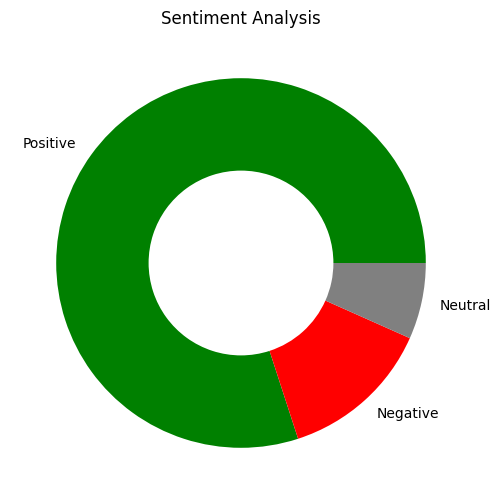

In [ ]:
# Creating our labels and assigning their corresponding count variables in lists.
labels = ['Positive', 'Negative', 'Neutral']
values = [pos, neg, neu]

# Creating a donut chart.
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.5), colors=['green', 'red', 'gray'])
ax.set_title('Sentiment Analysis with TextBlob')

plt.show()

Looking at the pie chart, we can see that most of the reviews in New York City hotels are positive, quite overwhelming if you ask me! It is around 80% positive, which is good to see! There is, of course, a few negative and neutral reviews from our sample pool as well.

Now, I will go ahead and run this same test on the NaiveBayesAnalyzer.

In [ ]:
# Creating 3 variables to count how many reviews were positive, negative, or neutral.
pos, neg, neu = 0, 0, 0

for r in reviews:
    blob = TextBlob(r, analyzer=NaiveBayesAnalyzer())
    sentiment = blob.sentiment

    if sentiment.classification == 'pos':
        pos
    elif sentiment.classification == 'neg':
        neg += 1
    else:
        neu += 1
    
print(f'Positive: {pos}, Negative: {neg}, Neutral: {neu}')

Positive: 43, Negative: 17, Neutral: 0


Now that we have our data for the donut chart, we will now make a donut chart. I will be using the code you provided in the starter notebook which you said was from ChatGPT, so here is just a quick statement for the citation.

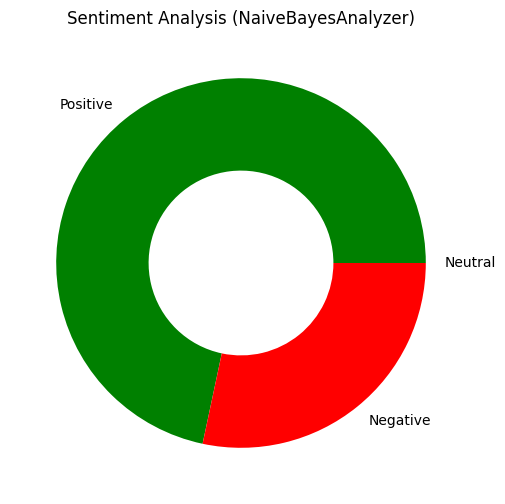

In [51]:
# Creating our labels and assigning their corresponding count variables in lists.
labels = ['Positive', 'Negative', 'Neutral']
values = [pos, neg, neu]

# Creating a donut chart.
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(values, labels=labels, wedgeprops=dict(width=0.5), colors=['green', 'red', 'gray'])
ax.set_title('Sentiment Analysis (NaiveBayesAnalyzer)')

plt.show()

Comparing the two, the main difference I see is that the NaiveBayesAnalyzer does not have any neutral reviews; it only gives a positive or negative result. Both of these donut charts have a similar trend of having overall positive reviews but in the NaiveBayesAnalyzer, there are a bit more negative reviews than what the regular TextBlob thought it was. 

Additioanlly, NaiveBayesAnalyzer is not as accurate; there's some wording that doesn't always flag as positive or negative when it clearly looks positive or negative from our end.

### **(d)** Delete the stop words from the reviews using the NLTK library stop-words lists.

Before we go on and loop through each review, we need to install the NLTK library of stop-words.

In [71]:
# Install the library of stop-words from NLTK.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now, I will go ahead and make a set of unique words in the stopwords.

In [72]:
# Create a set (unique words) of all of the stopwords in the English language (since our reviews are in English).
sw = set(stopwords.words('english'))

sw

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

I will now go ahead and concatenate all of the reviews together into 1 line just so that we don't need to have 60 different arrays of values and we can easily go ahead and get the word count with just 1 line of commands.

In [73]:
# Combine all of the reviews together into 1 string separated by a space so we can use the TextBlob easily.
reviews_str = ' '.join(reviews)

reviews_str

"Stayed here for about a week in July. Love that the AC is constantly running and the fact that they have a complimentary water spout for guests to use to... I've enjoyed staying at the CitizenM Bowery location, so when planning a Broadway-centered trip to NYC, I knew this would be a good choice.\n\nThe hotel is... Rooms are very small. Think of it as the hotel version of an efficiency apartment, they made it all fit in as little space as possible.\n\nAll of that would... We were thrilled with our stay here. Great location, easy to catch a subway, easy access to Brooklyn. Such a great community feel as we walked around the... This was a cute little hotel located in Chinatown with easy walking access to the financial district. I love that the subway was several blocks away, so... Excellent hospitality. Every staff member we ran into was amazing. The rooms were cozy, aesthetic, and had great views. Still sad I did not buy one of those... Perfectly appointed, clean and fashionable hotel. 

Now, I can go ahead and use the word_count function feature on the string to get a word count of each of the words in the string above. Since the string above is a mix of all of the reviews all in 1 string, we only need to run this command once to get all of the words for all of the reviews!

In [74]:
# Create a TextBlob of our review string and get the word count of every word in the reviews.
blob = TextBlob(reviews_str)
items = blob.word_counts.items()

items

dict_items([('stayed', 15), ('here', 15), ('for', 20), ('about', 3), ('a', 53), ('week', 3), ('in', 25), ('july', 1), ('love', 6), ('that', 13), ('the', 95), ('ac', 1), ('is', 21), ('constantly', 1), ('running', 1), ('and', 51), ('fact', 2), ('they', 10), ('have', 4), ('complimentary', 1), ('water', 1), ('spout', 1), ('guests', 1), ('to', 37), ('use', 1), ('i', 45), ('ve', 6), ('enjoyed', 1), ('staying', 2), ('at', 18), ('citizenm', 1), ('bowery', 1), ('location', 11), ('so', 6), ('when', 2), ('planning', 1), ('broadway-centered', 1), ('trip', 2), ('nyc', 7), ('knew', 1), ('this', 23), ('would', 10), ('be', 8), ('good', 7), ('choice', 2), ('hotel', 32), ('rooms', 7), ('are', 8), ('very', 10), ('small', 3), ('think', 1), ('of', 20), ('it', 14), ('as', 6), ('version', 1), ('an', 9), ('efficiency', 1), ('apartment', 1), ('made', 2), ('all', 10), ('fit', 1), ('little', 4), ('space', 1), ('possible', 1), ('we', 13), ('were', 8), ('thrilled', 1), ('with', 15), ('our', 3), ('stay', 12), ('gre

Now, I can easily go ahead and go through each of the different word counts and remove all of the stopwords. For this, I will go ahead and just remove all items that are in the stopwords set.

In [75]:
# Go through all of items and remove it if its in the stopwords set list.
words = [item for item in items if item[0] not in sw]

words

[('stayed', 15),
 ('week', 3),
 ('july', 1),
 ('love', 6),
 ('ac', 1),
 ('constantly', 1),
 ('running', 1),
 ('fact', 2),
 ('complimentary', 1),
 ('water', 1),
 ('spout', 1),
 ('guests', 1),
 ('use', 1),
 ('enjoyed', 1),
 ('staying', 2),
 ('citizenm', 1),
 ('bowery', 1),
 ('location', 11),
 ('planning', 1),
 ('broadway-centered', 1),
 ('trip', 2),
 ('nyc', 7),
 ('knew', 1),
 ('would', 10),
 ('good', 7),
 ('choice', 2),
 ('hotel', 32),
 ('rooms', 7),
 ('small', 3),
 ('think', 1),
 ('version', 1),
 ('efficiency', 1),
 ('apartment', 1),
 ('made', 2),
 ('fit', 1),
 ('little', 4),
 ('space', 1),
 ('possible', 1),
 ('thrilled', 1),
 ('stay', 12),
 ('great', 11),
 ('easy', 3),
 ('catch', 1),
 ('subway', 4),
 ('access', 2),
 ('brooklyn', 3),
 ('community', 1),
 ('feel', 1),
 ('walked', 1),
 ('around', 5),
 ('cute', 1),
 ('located', 2),
 ('chinatown', 1),
 ('walking', 3),
 ('financial', 1),
 ('district', 1),
 ('several', 3),
 ('blocks', 1),
 ('away', 3),
 ('excellent', 2),
 ('hospitality', 1),


### **(e)** Display a WordCloud of the top 20 words used in the reviews you cleaned.

For this section, I need to create a WordCloud of the top 20 words used in the reviews.

First of all,  I will first need to sort our words list so that the more frequent words are at the top and the least frequent words are at the bottom.

In [76]:
# Sort the words to have the more frequent ones at the top.
sorted_words = sorted(words, key=itemgetter(1), reverse=True)

sorted_words

[('hotel', 32),
 ('stayed', 15),
 ('staff', 13),
 ('stay', 12),
 ('location', 11),
 ('great', 11),
 ('clean', 11),
 ('would', 10),
 ('room', 9),
 ('one', 8),
 ('best', 8),
 ('nyc', 7),
 ('good', 7),
 ('rooms', 7),
 ('friendly', 7),
 ('place', 7),
 ('love', 6),
 ('like', 6),
 ('around', 5),
 ('night', 5),
 ('chose', 5),
 ('convenient', 5),
 ('little', 4),
 ('subway', 4),
 ('times', 4),
 ('back', 4),
 ('new', 4),
 ('close', 4),
 ('boutique', 4),
 ('service', 4),
 ('bar', 4),
 ('time', 4),
 ('week', 3),
 ('small', 3),
 ('easy', 3),
 ('brooklyn', 3),
 ('walking', 3),
 ('several', 3),
 ('away', 3),
 ('still', 3),
 ('quiet', 3),
 ('well', 3),
 ('bed', 3),
 ('beautiful', 3),
 ('absolutely', 3),
 ('york', 3),
 ('star', 3),
 ('price', 3),
 ('always', 3),
 ('pros', 3),
 ('let', 3),
 ('get', 3),
 ('ludlow', 3),
 ('spot', 3),
 ('incredibly', 3),
 ('years', 3),
 ('experience', 3),
 ('high', 3),
 ('hotels', 3),
 ('city', 3),
 ('breakfast', 3),
 ('wanted', 3),
 ('nice', 3),
 ('could', 3),
 ('two', 3)

Now, I will go ahead and only get the top 20 words of that list.

In [77]:
# Only get the top 20 words.
top_20 = sorted_words[0:21]

top_20

[('hotel', 32),
 ('stayed', 15),
 ('staff', 13),
 ('stay', 12),
 ('location', 11),
 ('great', 11),
 ('clean', 11),
 ('would', 10),
 ('room', 9),
 ('one', 8),
 ('best', 8),
 ('nyc', 7),
 ('good', 7),
 ('rooms', 7),
 ('friendly', 7),
 ('place', 7),
 ('love', 6),
 ('like', 6),
 ('around', 5),
 ('night', 5),
 ('chose', 5)]

Now, I will convert my list of top 20 words into a pandas dataframe so that we are able to graph a wordcloud and visualize it.

In [80]:
# Create a pandas dataframe with the top 20 words and their respective counts.
df = pd.DataFrame(top_20, columns=['word','count'])

df

,word,count
0,hotel,32
1,stayed,15
2,staff,13
3,stay,12
4,location,11
5,great,11
6,clean,11
7,would,10
8,room,9
9,one,8


Now, I will create a WordCloud of the top 20 words of the reviews.

In [ ]:
# I am making a WordCloud with the default colormap on a white background with a maximum of 20 words.
wordcloud = WordCloud(colormap='prism',background_color='white', max_words=20)

# I am converting my dataframe into a dictionary using the dict() and zip() functions so that we can generated from frequencies.
wordcloud = wordcloud.generate_from_frequencies(dict(zip(df['word'], df['count'])))

# Exporting the WordCloud to a png so we can see it.
wordcloud = wordcloud.to_file('Review.png')

This WordCloud has been exported to `Review.png` so we will be able to reference it outside of this notebook as well. I will now show the WordCloud below.

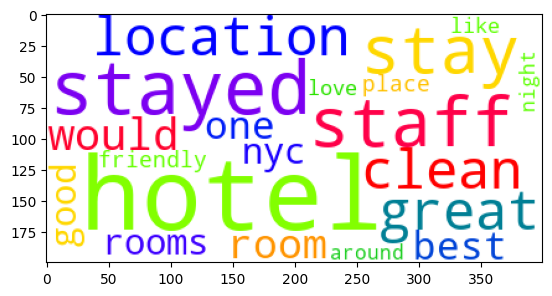

In [91]:
# Display our WordCloud.
plt.imshow(wordcloud)

From this WordCloud, we can see that reviews generally mention stuff about rooms, cleaning, the staff that work there, how friendly they are, the location that it's in (including New York City), and corresponds with our Sentiment Analysis with TextBlob and the NaiveBayesAnalzyer that there is a general similarity of positive wording.

### Conclusion 

To conclude my lovely analysis, it's safe to say that with our selection of 20 hotels in New York City, there is an overall positive opinion because of multiple factors: the friendly staff to work hard to keep rooms clean for guests, the location being at the heart of the city, the overall opinion by guests who say that their experience was "great" "best" and "good". Even so, many of the guests say that they "love" the hotel they said at.

Additionally, we can confirm that reviewers were talking about the hotel, as in our WordCloud, there are a bunch of hotel related words, with the most common word being "hotel" (explainable) and "room"/"rooms"/"stay"/"stayed".

All of the sentiment analysis proves that a good chunk of reviews were positive, with around 75%/80% using both our NaiveBayesAnalyzer and TextBlob sentiment analyzers. 